In [ ]:
import

In [3]:
import numpy as np
import pandas as pd
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from datetime import datetime
import matplotlib.pyplot as plt
from pylab import rcParams

In [4]:
path_0n20="./network_test/dtw/prom/not_n_rpkm20/cp1_init_df.csv"
path_0n30="./network_test/dtw/prom/not_n_rpkm30/cp1_init_df.csv"
path_0n50="./network_test/dtw/prom/not_n_rpkm50/cp1_init_df.csv"

df20=pd.read_csv(path_0n20)
df30=pd.read_csv(path_0n30)
df50=pd.read_csv(path_0n50)

lst20=df20["motif"].to_list()
lst30=df30["motif"].to_list()
lst50=df50["motif"].to_list()

In [5]:
# provide users our file:
all_df=pd.concat([df20,df30,df50], axis=0)
all_df.reset_index(drop=True, inplace=True)
# len(all_df)
all_df.to_csv("./init_concat.csv")

In [6]:
def motif_init2df(input_path="./init_concat.csv"):
    """
    Read init.csv file and convert it to 
    """
    df=pd.read_csv(input_path)
    data_lst=df["motif"].to_list()
    def convert_sequence(sequence, mapping):
        return [mapping[letter] for letter in sequence]
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                     'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    numerical_sequences=[convert_sequence(seq, letter_to_num) for seq in data_lst]
    df_sequences = pd.DataFrame(numerical_sequences).astype('Int64').T
    # Add an 'entry' column at the beginning of the DataFrame with labels 'Entry 1', 'Entry 2', etc.
    df_sequences.insert(0, 'position', ['Pos ' + str(i+1) for i in range(df_sequences.shape[0])])
    return df_sequences



In [7]:
def motif_init2pred(input_path="./init_concat.csv", n_clusters=11):
    """
    Read init.csv file and directly predict the class using DTW and k-mean
    """
    from tslearn.metrics import dtw

    df_sequences=motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    # Fill missing values with zero
    X_train_filled = X_train.fillna(0)
    # Then proceed with the DTW distance matrix computation
    n_series = X_train_filled.shape[0]
    dtw_distance_matrix = np.zeros((n_series, n_series))

    for i in range(n_series):
        for j in range(i, n_series):  # No need to compute the distance twice for (i, j) and (j, i)
            distance = dtw(X_train_filled[i], X_train_filled[j])
            dtw_distance_matrix[i, j] = distance
            dtw_distance_matrix[j, i] = distance
    seed=111
    start_time = datetime.now()
    # print("DTW k-means")
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
        n_init=10, #2,  # number of time you run with different initial centroid 
        metric="dtw",
        verbose=False, #True,
        max_iter_barycenter=10,
        random_state=seed)
    y_pred = dba_km.fit_predict(X_train.T)
    # print(y_pred)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return y_pred

In [8]:
y_pred=motif_init2pred()
y_pred

Duration: 0:00:11.401807


array([ 6,  0,  6,  9,  6,  1,  0, 10,  6,  0,  1,  0,  9,  6,  4,  6,  0,
        6, 10,  6,  6,  0,  6,  0,  6,  5, 10,  0, 10,  3,  7,  4,  3,  9,
        6,  4,  8,  7,  0,  2,  6,  6,  5,  5,  1,  6,  0,  7,  6,  4,  4,
        4,  0, 10,  6,  2,  3, 10,  6,  6,  6,  9, 10,  9, 10,  1,  6,  5,
        1,  6,  4,  3,  0,  1,  3,  8,  1,  1,  1,  5,  6,  1,  6,  4,  4,
        1,  5,  6,  8,  8,  0,  6,  1,  2,  1,  7,  3,  6,  7,  1,  0,  7,
        8,  9,  4,  5,  3,  9,  3,  1,  5,  8,  8, 10,  1,  1])

In [9]:
from tqdm.notebook import tqdm  # Import the notebook version of tqdm

def motif_init2elbow(input_path="./init_concat.csv", n_start=1, n_end=25):
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    n_cluster_range = range(n_start, n_end + 1)
    inertia = []
    seed = 111
    
    # Wrap n_cluster_range with tqdm for the progress bar
    for n_clusters in tqdm(n_cluster_range, desc="Calculating clusters"):
        model = TimeSeriesKMeans(n_clusters=n_clusters,
                                 metric="dtw",
                                 verbose=False,
                                 max_iter_barycenter=10,
                                 random_state=seed)
        model.fit(X_train.T)
        inertia.append(model.inertia_)
        # The tqdm progress bar replaces the need for the print statement
        
    # Filter out infinite values and their corresponding cluster numbers
    finite_inertia = [i for i in inertia if np.isfinite(i)]
    n_cluster_finite = list(n_cluster_range)[:len(finite_inertia)]

    # Plotting the inertia with finite values only
    plt.figure(figsize=(12, 6))
    plt.plot(n_cluster_finite, finite_inertia, marker='o')
    plt.title('Elbow Method For Optimal Cluster Number', fontsize=16)
    plt.xlabel('Number of clusters', fontsize=16)
    plt.ylabel('Inertia', fontsize=16)
    plt.xticks(n_cluster_finite, fontsize=12)  # Increase x-axis ticks font size
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()


Calculating clusters:   0%|          | 0/25 [00:00<?, ?it/s]

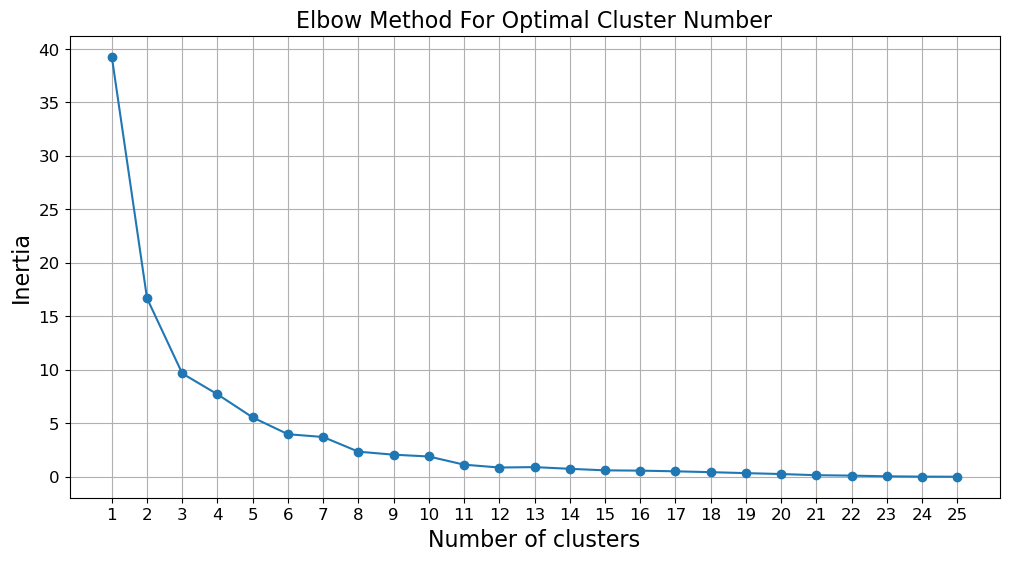

In [10]:
motif_init2elbow()

In [11]:
def motif_init2class_df(input_path="./init_concat.csv", n_clusters=11):
    df_sequences=motif_init2df(input_path=input_path)

    # Transpose df_test so that each entry becomes a row
    df_seq_transposed = df_sequences.T  
    # The first row will likely contain something other than data (e.g., time points), so let's keep it as a header
    new_header = df_seq_transposed.iloc[0]  # Grab the first row for the header
    df_seq_transposed = df_seq_transposed[1:]  # Take the data less the header row
    df_seq_transposed.columns = new_header  # Set the header row as the df header
    # Reset the index to make the entries into a column
    df_seq_transposed.reset_index(inplace=True)
    # Rename the 'index' column to something more descriptive, like 'Entry'
    df_seq_transposed.rename(columns={'index': 'Entry'}, inplace=True)

    y_pred=motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    # Add the cluster labels as a new column
    df_seq_transposed['Cluster'] = y_pred
    # Sort the DataFrame by the 'Cluster' column
    df_sorted_by_cluster = df_seq_transposed.sort_values(by='Cluster')
    # Reset the index of the sorted DataFrame
    df_sorted_by_cluster.reset_index(drop=True, inplace=True)
    # Display the sorted DataFrame
    # df_sorted_by_cluster
    # Reverse the letter_to_num mapping
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                        'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    num_to_letter = {v: k for k, v in letter_to_num.items()}

    # Function to convert a series of numbers to a letter string, ignoring NaNs
    def series_to_letters(series):
        return ''.join([num_to_letter.get(x, '') for x in series if pd.notna(x)])

    # Apply the conversion to each row (excluding the 'Cluster' column) and add the result to a new column
    df_sorted_by_cluster['LetterSequence'] = df_sorted_by_cluster.drop('Cluster', axis=1).apply(series_to_letters, axis=1)

    # Group by 'Cluster' and aggregate 'LetterSequence' into lists
    clustered_sequences = df_sorted_by_cluster.groupby('Cluster')['LetterSequence'].apply(list).reset_index()

    # Display the result
    return clustered_sequences

In [12]:
clustered_sequences=motif_init2class_df()

Duration: 0:00:10.776730


In [13]:
clustered_sequences

,Cluster,LetterSequence
0,0,"[KDDDDDDD, DDDDDDDEEE, DDDEE, DDDDD, DDDDEEEEE..."
1,1,"[CCCAA, BBBBA, AAAAA, BBAAAA, BBAAA, CCAAA, BA..."
2,2,"[OAAAA, OOOAAA, OOOAAAAA]"
3,3,"[GBBBB, GGBBB, GBBAA, GGBAAA, GBAAAAA, GBBBAA,..."
4,4,"[FFFFFFFFF, FFFFF, FFFFFFF, DFFFF, FFFFFFFFFFF..."
5,5,"[AAAAAEEE, AAEEE, AAAAEEEE, AAAEEEEE, AAAEE, A..."
6,6,"[EEEEEEDD, EEEEEEEEDD, EEEEEEED, EEEED, EEEED,..."
7,7,"[EEEAAAA, EEEAA, EAAAAA, EEEAAA, EEEAAAA, EAAAA]"
8,8,"[FFFFFFFCCCC, FFDDD, FFFDDD, FFFFFFD, FFCCC, F..."
9,9,"[CBBGGG, CCFFFF, CFFFF, CCCFFF, LCCFFF, CCFFFF..."


In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11):
    df_sequences=motif_init2df(input_path=input_path)
    y_pred=motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    from itertools import cycle

    # Set the figure size and legend location
    rcParams["figure.figsize"] = 12, 6
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_test is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    cluster_colors = {
        0: (0.12, 0.47, 0.71),    # Blue
        1: (0.68, 0.78, 0.91),    # Light Blue
        2: (1.0, 0.50, 0.05),     # Orange
        3: (1.0, 0.73, 0.47),     # Light Orange
        4: (0.17, 0.63, 0.17),    # Green
        5: (0.60, 0.87, 0.54),    # Light Green
        6: (0.84, 0.15, 0.16),    # Red
        7: (1.0, 0.60, 0.59),     # Light Red
        8: (0.58, 0.40, 0.74),    # Purple
        9: (0.77, 0.69, 0.84),    # Light Purple
        10: (0.55, 0.34, 0.29)    # Brown
    }

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Plot each item with its corresponding color and line style
    for index, item in enumerate(item_list):
        color = cluster_colors[y_pred[index]]
        linestyle = cluster_linestyles[y_pred[index]]
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=str(item)+"_cluster"+str(y_pred[index]), 
                color=color, linestyle=linestyle)

    # Set x-tick labels with rotation
    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences["position"].astype(str), rotation=45)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11):
    df_sequences = motif_init2df(input_path=input_path)
    y_pred = motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    from itertools import cycle

    # Set the figure size and legend location
    rcParams["figure.figsize"] = (12, 6)
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_sequences is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Plot each item with its corresponding color (automatically determined by matplotlib) and line style
    for index, item in enumerate(item_list):
        linestyle = cluster_linestyles[y_pred[index]]
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=f"{item}_cluster{y_pred[index]}", 
                linestyle=linestyle)

    # Set x-tick labels with rotation
    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences["position"].astype(str), rotation=45)

    # Add a legend
    # plt.legend()

    # Show the plot
    plt.show()


Duration: 0:00:12.498057


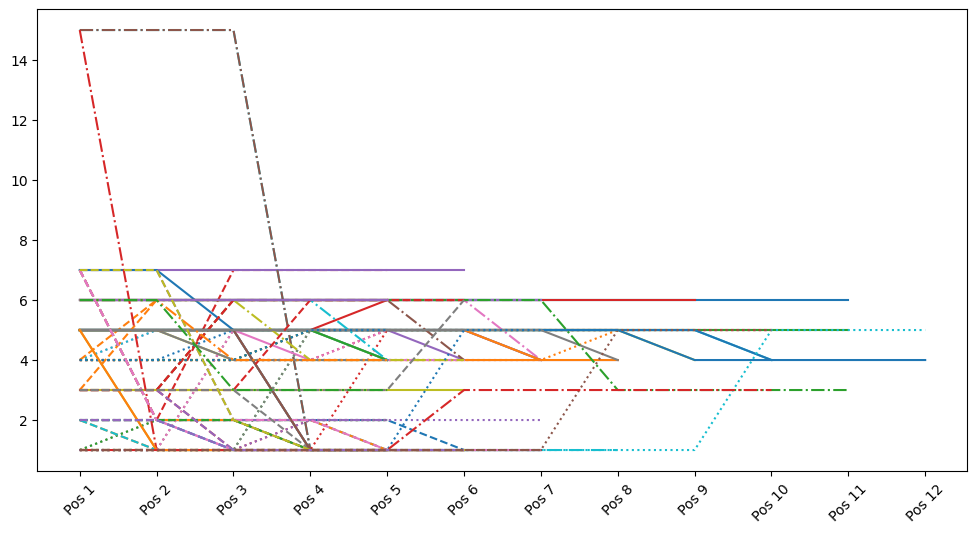

In [16]:
motif_init2class_vis(n_clusters=14)

In [27]:
def motif_init2umap(input_path="./init_concat.csv", n_clusters=11, n_neighbors=5, min_dist=0.3, random_state=111):
    """
    Generate a UMAP embedding of the given data.

    Parameters:

    - input_path: .csv file of all motifs with high attention score
    
    - n_clusters: number of clusters

    - n_neighbors: int (default=5), The size of local neighborhood (in terms of number of neighboring sample points) 
      used for manifold approximation. Larger values result in a more global view of the manifold, while smaller values emphasize local data structures. 
      Adjust according to the desired granularity of the embedding.
      
    - mid_dist: float (default=0.3), The minimum distance between embedded points in the low-dimensional space. 
      Smaller values allow points to cluster more tightly in the embedding, which is useful for identifying finer substructures within the data. 
      Larger values help preserve the overall topology of the data by preventing points from clustering too tightly.
    """
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    X_train = X_train.astype('float64')  # Convert to float64
    X_filled = X_train.fillna(X_train.mean())

    y_pred = motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    # Now apply UMAP on the cleaned data
    from umap import UMAP
    # # seed=111
    # # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
    # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_jobs=1)

    umap_embedding = umap_reducer.fit_transform(X_filled.T)  # Ensure the data is transposed if necessary

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='white', linewidth=0.6)

    # Create a color bar with ticks for each cluster label
    colorbar = plt.colorbar(scatter, ticks=np.arange(0, 11))
    colorbar.set_label('Cluster label')

    # Set the plot title and labels
    plt.title('UMAP Projection After K-means clustering', fontsize=20)
    plt.xlabel('UMAP Dimension 1', fontsize=15)
    plt.ylabel('UMAP Dimension 2', fontsize=15)

    # Show the plot
    plt.show()

Duration: 0:00:11.033547


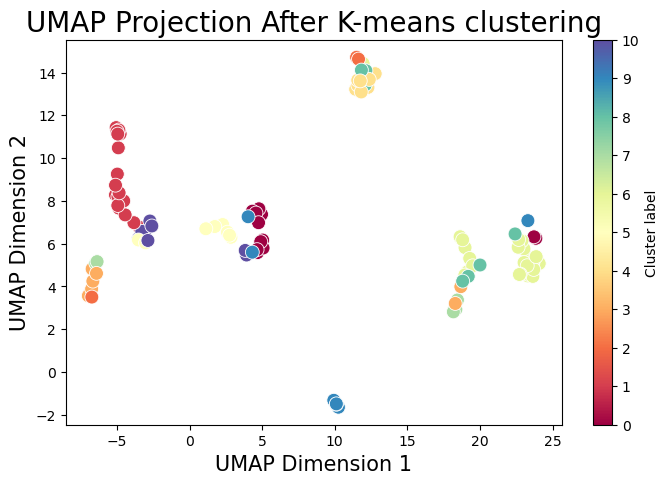

In [28]:
motif_init2umap()

In [4]:
from css_utility import *
import ast

In [12]:
crp_df["A"][0]

0.1836419753086419

In [ ]:
          G         B         B         B         G
0  0.037423  0.000000  0.000000  0.000000  0.000000
1  0.000000  0.056624  0.000000  0.000000  0.000000
2  0.000000  0.000000  0.042596  0.000000  0.000000
3  0.000000  0.000000  0.000000  0.044513  0.000000
4  0.000000  0.000000  0.000000  0.000000  0.035308

In [11]:
original_df = pd.DataFrame({
    'G': [0.037423, 0, 0, 0, 0],
    'B': [0, 0.056624, 0, 0, 0],
    'B': [0, 0, 0.042596, 0, 0],
    'B': [0, 0, 0, 0.044513, 0],
    'G': [0, 0, 0, 0, 0.035308]
})

# Transpose the DataFrame to separate the rows by characters
transposed_df = original_df.T
# Create individual DataFrames for each character
g_df = transposed_df.loc['G'].T
b_df = transposed_df.loc['B'].T

# Reset column names to be unique
g_df.columns = [f'G{i}' for i in range(len(g_df.columns))]
b_df.columns = [f'B{i}' for i in range(len(b_df.columns))]

AttributeError: 'Series' object has no attribute 'columns'

In [10]:
transposed_df

,0,1,2,3,4
G,0.0,0.0,0.0,0.000000,0.035308
B,0.0,0.0,0.0,0.044513,0.000000


In [2]:
path="../database/roadmap/prom/up2kdown4k/all_genes/E003_prom_up2kdown4k.pkl"
with open(path, "rb") as f:
    data=pickle.load(f)

In [4]:
len(data[0])

2060

In [8]:
test_data=data[0][40:60]

In [13]:
colored_css_str_as_is(test_data[0])

EGGGBAAAAAAAABBEEEEEEEEDDDDEEE


In [14]:
for item in test_data:
    colored_css_str_as_is(item)

EGGGBAAAAAAAABBEEEEEEEEDDDDEEE
EHHHEEEEEEEEEEEEEEEEEEEEEEEEEE
EEEEBBGGGGGGGGGBKKKKKKJJKKLLGG
GGEEEEEDDFBBBAAAAAAAAAAAEEEEEE
EEEEEEEDDDDDDDDDDDDDDDDDDDDDDD
DFCCCAAAAAAAABBBFFFFFFFFDDDDDD
EEEEEEEEEEEEEEGGGBAABGGGGGGGGG
EEEEEEGGGGGGGEEEAAAEHEEEEEEEGG
HEEEEEEEGGGGGGGGGGGGGGGGGGGGGB
GGBBBBBBBBAAABKKGEEEEEEEEEDDDD
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOAAAAAAAAAAAAAEEEEEEEEEEEEE
OOOOAAAAAAAAAAAGGGEEEEEEEEEEEE
EEEEEEEEEEEEDEEEEEEEEEEEEDDDEE
AAAAAABBFDDDDDDDDDDDDDDDDDDDDD
MMMMLLLLLLLLLLLKKJJJJJJKLMMMMM
OOOOAAAAAAAAAAABBGEEEEEEEEEEEE
MJJJJJJJJJJJEEEEEEEEEEEEEEEEEE
EEEEEEEEEEEEEEEEDDDDDDEEEEEEEE
EEAAAAAAAAAAEEEEEEEEEEEEEEEEEE


In [136]:
def extract_numbers(s):
    numbers = re.findall('\d+', s)
    numbers = [int(number) for number in numbers]
    return numbers

In [118]:
def convert_to_array(s):
    # Find all arrays in the string
    arrays_str = re.findall(r'array\(\[.*?\]\)', s.replace('\n', ''))

    arrays = []
    for arr_str in arrays_str:
        # Remove 'array([' from the start and '])' from the end
        s_trimmed = arr_str[7:-2]
        # Convert string to array
        array = np.fromstring(s_trimmed, sep=',')
        arrays.append(array)
    
    return arrays

In [143]:
def read_motif_score_file(path):
    df_raw=pd.read_csv(path, header=None)
    df=df_raw.T
    df=df.dropna()
    df.columns=["seq", "index", "position", "score"]
    df=df[["index", "position","seq","score"]]
    df["index"]=df["index"].apply(extract_numbers)
    df["position"]=df["position"].apply(ast.literal_eval)
    df["score"]=df["score"].apply(convert_to_array)
    return df

In [167]:
def filtered_motif_n_score(score_path,filter_path):
    """
    score_path: the file for extracting motif and corresponding attention scores
    filter_path: the file consists of "motif", "N", "K", "n", "x", "p"
    """
    # motif scores are extracted for "all high attention area" meets the conditions
    df=read_motif_score_file(score_path)
    # filter is for p<0.05
    fil_df=pd.read_csv(filter_path)
    fil_df.rename(columns={'motif': 'seq'}, inplace=True)
    df_merged=pd.merge(df, fil_df, on="seq")
    return df_merged

In [168]:
df_merged=filtered_motif_n_score(score_path="test_extract_df.csv",filter_path="init_df.csv")

In [173]:
df_merged["seq"].unique()

array(['EDDDDDDDDD', 'GGEEGE', 'EDDDDEE', 'MMMMLL', 'JJJJJJMM', 'EEDDD',
       'GGGEEGE', 'GGBGBGG', 'JJJJM', 'GBBGGG', 'EEGEEEE', 'JJJJJM',
       'JJJJJJJJJ', 'EEDDDDDDDEE', 'EDDDDDEE', 'EEDDEE', 'EEEDDD',
       'EEDDDD', 'AAABEE', 'KKLLL', 'AABBEE', 'EEEEE', 'MJJJJJ', 'GGBBAA',
       'EEDEEE', 'GGBGEE', 'GGGEE', 'AAABGEE', 'JJJJJJ', 'AAABBEEE',
       'EEEDDDDDD', 'EEEDDDDDEE', 'EEDDDDDDDDDDDD', 'EEEDDDDDDDEE',
       'EEEDDDE', 'EEDDDDEE', 'GGBGGG', 'ABBGGG', 'AAABEEE', 'EEGGGG',
       'EEDDDEEEEE', 'AAAAB', 'AAAAA', 'HDDDD', 'EDDDDDDDDDDDDDD',
       'AAAAGEEE', 'AAAAAAAA', 'EEEEEEDDD', 'EEEGGGGGGG', 'LMMMM',
       'DDDDDDDD', 'AABEE', 'EEEEEEEE', 'BGGGGGGG', 'EEEEEEEEEEEEE',
       'DDDDDDD', 'HHHHHHH', 'EEEEEE', 'EEEEEEEEEDDDDE', 'EEEEGG',
       'EEEEEEDD', 'BEEEEEE', 'MMJJJJ', 'LLLKK', 'EEEEEEEEEEEE', 'EEEDD',
       'DDDDDDDDDEEE', 'EEEEEEED', 'DDDDD', 'GGGGGGGGE', 'BGEEE',
       'EEEEEEE', 'AAAAAAABB', 'EEEEEEEEEEEEEGG', 'EEEEEGGGEEEE',
       'EEDDDDDEE', 'ABBGEEEEE',

In [203]:
def extStrong_prom(prom_path="../database/roadmap/prom/up2kdown4k/gene_exp/", rpkm_val=50, chromatin_state="A"):#, output_path=):
    """Gather the strong promoter regions at once"""
    prom_path_subdir=os.listdir(prom_path)
    prom_path_tardir=[os.path.join(prom_path, subdir) for subdir in prom_path_subdir if str(rpkm_val) in subdir][0]
    if rpkm_val==0:
        prom_path_tardir=os.path.join(prom_path, "rpkm0")
        
    prom_files=sorted([os.path.join(prom_path_tardir,file) for file in os.listdir(prom_path_tardir)])
    
    strong_prom_all=[]
    for file in prom_files:
        cell_id=file.split("/")[-1][:4]
        if cell_id=="E004":break ## for test
        with open(file,"rb") as f:
            prom_lst_chr=pickle.load(f) # list by chromosome
        prom_all=flatLst(prom_lst_chr) # flattened, now a list of strings (prom)
        strong_prom=[]
        for prom in prom_all:
            if chromatin_state in prom:
                strong_prom.append(prom)
        strong_prom_all.append(strong_prom)
    strong_prom_all=flatLst(strong_prom_all)
    return strong_prom_all

In [205]:
def extWeak_prom(prom_path="../database/roadmap/prom/up2kdown4k/gene_exp/not_exp/", chromatin_state="A"):#, output_path=):
    """Gather the Weak promoter regions at once"""   
    prom_files=sorted([os.path.join(prom_path,file) for file in os.listdir(prom_path)])
    
    weak_prom_all=[]
    for file in prom_files:
        cell_id=file.split("/")[-1][:4]
        if cell_id=="E004":break ## for test
        with open(file,"rb") as f:
            prom_lst_chr=pickle.load(f) # list by chromosome
        prom_all=flatLst(prom_lst_chr) # flattened, now a list of strings (prom)
        weak_prom_all=[]
        for prom in prom_all:
            if chromatin_state in prom:
                weak_prom.append(prom)
        weak_prom_all.append(weak_prom)
    weak_prom_all=flatLst(weak_prom_all)
    return weak_prom_all

In [189]:
prom_test="../database/roadmap/prom/up2kdown4k/gene_exp/rpkm50/E003_prom_up2kdown4k.pkl"

In [190]:
with open(prom_test,"rb") as f:
    data=pickle.load(f)

In [196]:
data_flat=flatLst(data)

In [201]:
len(data_flat)

1229

In [35]:
#### merge_intervals # for a list of dataframe, you can run it after running Gexp_Gene2GLChr

In [43]:
gene_file_path="../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat"

In [67]:
gene_file_path_116="../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E116_gene_highlyexpressed.refFlat"

In [79]:
with open("../database/roadmap/df_pickled/E003_df_pickled.pkl","rb") as f:
    df=pickle.load(f)

In [68]:
with open("../database/roadmap/df_pickled/E116_df_pickled.pkl","rb") as f116:
    df116=pickle.load(f116)

In [111]:
exp_gene_dir="../database/roadmap/gene_exp/refFlat_byCellType/"
exp_gene_files=os.listdir(exp_gene_dir)

In [112]:
exp_gene_files

['rpkm50', 'rpkm30', 'rpkm20', 'rpkm10', 'rpkm0']

In [115]:
exp_gene_subdir=os.listdir(exp_gene_dir)
exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if str(50) in subdir]

In [183]:
def extNsaveProm_g_exp(exp_gene_dir="../database/roadmap/gene_exp/refFlat_byCellType/", df_pickle_dir="../database/roadmap/df_pickled/",output_path="../database/roadmap/prom/up2kdown4k/gene_exp/",rpkm_val=50, up_num=2000, down_num=4000,unit=200):
    exp_gene_subdir=os.listdir(exp_gene_dir)
    exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if str(rpkm_val) in subdir][0]
    if rpkm_val==0:
        exp_gene_tardir=os.path.join(exp_gene_dir, "rpkm0")
    
    # If the directories are named something like 'subdir_0' and 'subdir_50':
#     exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if re.match(f'subdir_{rpkm_val}$', subdir)][0]

    exp_gene_files=sorted([os.path.join(exp_gene_tardir,file) for file in os.listdir(exp_gene_tardir)])
    
    for exp_gene_file in exp_gene_files:
        cell_id=exp_gene_file.split("/")[-1][:4]
#         if cell_id=="E004":break ## for test
        df_name=[file for file in os.listdir(df_pickle_dir) if cell_id in file][0]
        df_path=os.path.join(df_pickle_dir,df_name)
        with open(df_path,"rb") as f:
            df=pickle.load(f)
        css_prom_lst_unit_all=extProm_wrt_g_exp(exp_gene_file, df, up_num=up_num, down_num=down_num,unit=unit)
           
        output_name=output_path+"rpkm"+str(rpkm_val)+"/"+cell_id+"_prom_up2kdown4k.pkl"
        output_dir = os.path.dirname(output_name)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        with open(output_name, "wb") as g:
            pickle.dump(css_prom_lst_unit_all,g)
    return print("Saved at ",output_path)

In [184]:
extNsaveProm_g_exp(rpkm_val=0)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


## This should be run for other rpkm!

In [172]:
extNsaveProm_g_exp(rpkm_val=50)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


In [173]:
extNsaveProm_g_exp(rpkm_val=30)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


In [174]:
extNsaveProm_g_exp(rpkm_val=20)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


In [175]:
extNsaveProm_g_exp(rpkm_val=10)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


In [176]:
extNsaveProm_g_exp(rpkm_val=0)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Saved at  ../database/roadmap/prom/up2kdown4k/gene_exp/


In [170]:
def extProm_wrt_g_exp(exp_gene_file, df, up_num=2000, down_num=4000,unit=200):
    """
    extract promoter regions of genes according to gene expression level
    """
    df = df[df['chromosome'] != 'chrM']
    g_lst_chr=Gexp_Gene2GLChr(exp_gene_file)
    g_lst_chr_merged=merge_intervals(g_lst_chr)
    
    css_prom_lst_all=prom_expGene2css(g_lst_chr_merged,df, up_num=up_num, down_num=down_num)
    css_prom_lst_unit_all=Convert2unitCSS_main_new(css_prom_lst_all, unit=unit)
    return css_prom_lst_unit_all

In [171]:
def prom_expGene2css(g_lst_chr_merged,df, up_num=2000, down_num=4000):   # df indicates css, created by bed2df_expanded
    """
    modified from `compGene2css`
    Input: Reference gene file traimmed for gene expresseion level, df (CSS)
    Output: list of chromosome-wise list that contains the css at (expressed) genic area with prom only.
    """
    g_lst_chr=g_lst_chr_merged
    df = df[df['chromosome'] != 'chrM']
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    
    g_lst_chr = g_lst_chr[:len(css_lst_chr)]  # adjust the length of list according to length of df (might not have chrY)
    total_chr=len(css_lst_chr)
    
    print("Matching to the chromatin state sequence data ...")
    css_prom_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_prom_lst_chr=[]
        for j in range(len(gene_df)):
            prom_start=gene_df["TxStart"].iloc[j]-1-up_num  # python counts form 0
            prom_end=prom_start+up_num+down_num+1      # python excludes the end
            if gene_df["TxEnd"].iloc[j]<prom_end:  # if longer than gene body, then just gene body
                prom_end=gene_df["TxEnd"].iloc[j]+1
    
            css_prom=css[prom_start:prom_end]           # cut the gene area only
            css_prom_lst_chr.append(css_prom)     # store in the list
          
        css_prom_lst_all.append(css_prom_lst_chr)  # list of list
    
    assert len(css_prom_lst_all)==total_chr
    
    # remove chromosome if it is empty (e.g. chrY for female)
    css_prom_lst_all=[elm for elm in css_prom_lst_all if elm!=[]] 
    
    print("Done!")
    return css_prom_lst_all 

In [156]:
css_prom_lst_all=prom_expGene2css(exp_gene_file,df, up_num=2000, down_num=4000)

NameError: name 'exp_gene_file' is not defined

In [157]:
css_prom_lst_unit_all=extProm_wrt_g_exp('../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat', df, up_num=2000, down_num=4000,unit=200)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [159]:
css_prom_lst_unit_all[0][5]

'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [106]:
len(css_prom_lst_all)

23

In [149]:
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [34]:
g_df_chr_collapsed_lst[0]

,TxStart,TxEnd
0,955502,991496
1,1716728,1822495
2,6281252,6296000
3,8021751,8045565
4,8921060,8938749
...,...,...
129,228270360,228286912
130,229566991,229569841
131,235272650,235292251
132,236139129,236228462


In [25]:
len(flatLst(g_df_chr_collapsed_lst))

48

In [32]:
len(g_df_chr_collapsed_lst[3])

31

In [20]:
g_df_chr_collapsed_lst_m=merge_intervals(g_df_chr_collapsed_lst)

In [33]:
len(g_df_chr_collapsed_lst_m[3])

31

In [ ]:
merge_intervals # for a list of dataframe, you can run it after running Gexp_Gene2GLChr

In [3]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm30/E003_rpkm30_exp_gene_css.pkl","rb") as f3:
    r30_e3=pickle.load(f3)

In [4]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm30/E116_rpkm30_exp_gene_css.pkl","rb") as f116:
    r30_e116=pickle.load(f116)

In [5]:
len(r30_e3)

2222

In [16]:
r30_e3[6]

'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEEGGGGGGGGGGGGGGGGGGGGGBGAAAAABGGGAAAAAAA'

In [6]:
len(r30_e116)

2321

In [15]:
r30_e116[6]

'AAABBBBBBEEEEEEEEEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [19]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl","rb") as f3:
    ref=pickle.load(f3)

In [20]:
len(ref)

24

In [21]:
with open("../database/roadmap/gene_css_unit_pickled/E116_gene_css_pickled.pkl","rb") as f4:
    ref2=pickle.load(f4)

In [22]:
len(ref2)

24

In [3]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl","rb") as f:
    cont=pickle.load(f)

In [23]:
len(cont["chromosome"].unique())

25

In [15]:
with open("../database/roadmap/df_pickled/E116_df_pickled.pkl","rb") as g:
    test=pickle.load(g)

In [16]:
test["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrM', 'chrX'], dtype=object)

In [17]:
with open("../database/roadmap/df_pickled/E117_df_pickled.pkl","rb") as g2:
    test2=pickle.load(g2)

In [18]:
test2["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrM', 'chrX'], dtype=object)

In [12]:
with open("../database/roadmap/Ngene_css_unit_pickled/E001_Ngene_css_pickled.pkl","rb") as ff:
    cont_css=pickle.load(ff)

In [371]:
with open("../database/roadmap/Ngene_css_unit_pickled/E090_Ngene_css_pickled.pkl", "rb") as f:
    data_test=pickle.load(f)

In [372]:
data_test[0][111]

'NNNNNNNMKJJKKLMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMNNNNNNNNNNNNNNNNGGGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGGEEGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIINNNNNNNNNNNNNLLLLMMMMMMMMMMLLK'

In [369]:
with open("../database/roadmap/Ngene_css_unit_pickled/E080_Ngene_css_pickled.pkl", "rb") as f2:
    data_test2=pickle.load(f2)

In [370]:
data_test2[0][111]

'GGGGGGGGBAABBGGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGBBGOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGGGGGGGEEEEGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOOOOOOOOOOOOOOOOOOGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEGGGLLLLLLLMMMMMMMMLK'

In [342]:
with open("../database/roadmap/sample_E001_gene_css_pickled.pkl", "rb") as f_g:
    data_test_g=pickle.load(f_g)

In [345]:
data_test_g[0][110]

'AAAAAEEEEEEEEEDDDDDEEEEEEEEEEDDDDDDDDDDEEEEEEEEEEE'

In [238]:
raw_gene_table=whGene2GLChr(whole_gene_file) #chromosome-wise data frame

Extracting the gene file ...
Done!


In [240]:
raw_gene_table[0]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
...,...,...,...,...
5247,chr1,249144202,249153315,NM_001193328
5249,chr1,249144202,249153125,NM_001136036
5250,chr1,249144202,249153315,NM_017865
5253,chr1,249200441,249213345,NM_001017434


In [241]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [245]:
gene_collapsed_df=removeOverlapDF(raw_gene_table[0])

In [248]:
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i]==gene_collapsed_df["TxStart"].iloc[i+1]:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

58 1570602
61 1682670
68 1981908
69 1981908
79 2517898
89 3569128
114 6521213
115 6521213
116 6521213
123 6684924
126 6845383
137 8921058
143 9208069
150 9711789
153 9982170
177 11822249
178 11822249
179 11822249
180 11822249
213 14925212
220 15802595
301 20959947
302 20959947
308 21543739
335 23685940
357 24645811
358 24645811
376 26146396
392 26608772
445 29213602
446 29213602
477 32674694
530 36602169
567 39957317
573 40204516
590 41154751
595 41480261
596 41480261
603 42642209
621 43629844
622 43629844
640 44457279
660 45794913
661 45794913
664 45965855
672 46505811
674 46654352
683 47004367
700 47846467
715 51752929
716 51752929
719 52082545
739 53692563
751 54492353
752 54492353
800 63786554
801 63786554
817 65886130
831 68167148
832 68167148
843 71318035
844 71318035
868 78412166
880 84041470
886 84944919
887 84944919
967 95558072
981 100111430
1013 108113781
1052 110453232
1070 111196185
1087 112264685
1109 114355233
1110 114355233
1113 114466622
1131 116461996
1134 116915794
1

In [ ]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in range(len(g_df_chr_lst)):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all

In [251]:
def merge_intervals(df):
    # Sort by 'TxStart'
    df = df.sort_values(by='TxStart')

    # Initialize an empty list to store the merged intervals
    merged = []

    # Iterate through the rows in the DataFrame
    for _, row in df.iterrows():
        # If the list of merged intervals is empty, or the current interval does not overlap with the previous one,
        # append it to the list
        if not merged or merged[-1]['TxEnd'] < row['TxStart']:
            merged.append(row)
        else:
            # Otherwise, there is an overlap, so we merge the current and previous intervals
            merged[-1]['TxEnd'] = max(merged[-1]['TxEnd'], row['TxEnd'])

    # Convert the merged intervals back into a DataFrame
    return pd.DataFrame(merged)

In [264]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [252]:
df = pd.DataFrame({
    'TxStart': [1, 50, 120, 150, 170, 210, 250],
    'TxEnd': [100, 120, 130, 170, 200, 220, 300]
})

new_df = merge_intervals(df)
print(new_df)

   TxStart  TxEnd
0        1    130
3      150    200
5      210    220
6      250    300


In [255]:
test=merge_intervals(raw_gene_table[0])

In [256]:
gene_collapsed_df=test
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i]==gene_collapsed_df["TxStart"].iloc[i+1]:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

In [257]:
gene_collapsed_df

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,29370,NR_046018
1464,chr1,30365,30503,NR_036266
1461,chr1,34610,36081,NR_026820
1459,chr1,69090,70008,NM_001005484
1466,chr1,134772,140566,NR_039983
...,...,...,...,...
5248,chr1,249104650,249120154,NM_030645
5252,chr1,249120575,249120642,NR_036070
5251,chr1,249132376,249143716,NM_024836
5247,chr1,249144202,249153315,NM_001193328


In [ ]:
path="../database/css_pickled/"

In [125]:
new_gene_lst_all=gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed')

Extracting the gene file ...
Done!


In [133]:
[i for i in new_gene_lst_all[0]["TxStart"]-new_gene_lst_all[0]["TxEnd"] if i >0]

[]

In [130]:
len(new_gene_lst_all[-1])

121

In [266]:
def compNonGene2css_fixing(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
    
    print("Extracting the CSS on the intergenic region ...")

    ########### new fancy gene table without overlap ###########
#     new_gene_lst_all=gene_removeDupl(whole_gene_file)
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=merge_intervals(g_df_chr_lst)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
        
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking 
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr) 
        
    assert len(css_Ngene_lst_all)==total_chr
    print("Done!")
    
    return css_Ngene_lst_all

In [267]:
css_Ngene_lst_all=compNonGene2css_fixing(whole_gene_file,df)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


AttributeError: 'list' object has no attribute 'sort_values'

In [265]:
merge_intervals(whole_gene_file)

AttributeError: 'str' object has no attribute 'sort_values'

In [260]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [141]:
def compGene2css_fixed(whole_gene_file,df):   # note that the result is also overlapped css... 
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at genic area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    
    ########### new fancy gene table without overlap ###########
    g_lst_chr=gene_removeDupl(whole_gene_file) # should be further fixed
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all

In [259]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl", "rb") as f:
    df=pickle.load(f)

In [143]:
css_gene_lst_all=compGene2css_fixed(whole_gene_file,df)

Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

In [153]:
len(css_gene_lst_all[3])

874

In [147]:
css_gene_lst_all_old=compGene2css(whole_gene_file,df)

Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

In [148]:
len(css_gene_lst_all_old[0])

5255

In [ ]:
css_gene_lst_all_old

In [149]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [152]:
len(css_Ngene_lst_all[3])

874

In [154]:
total_chr=len(new_gene_lst_all)

In [155]:
total_chr

24

In [156]:
########### new fancy gene table without overlap ###########
new_gene_lst_all=gene_removeDupl(whole_gene_file)
############################################################

css_lst_chr=df2longcss(df) # list of long css per chromosome
total_chr=len(new_gene_lst_all)

Extracting the gene file ...
Done!


In [159]:
new_gene_lst_all[0]

,TxStart,TxEnd
0,11873,29370
1,30365,30503
2,34610,36081
3,69090,70008
4,134772,140566
...,...,...
2183,249104650,249120154
2184,249120575,249120642
2185,249132376,249143716
2186,249144202,249153315


In [163]:
len(css_lst_chr[0])

249250600

In [166]:
len(css_gene_lst_all[0])

2188

In [231]:
# test for chromosome 1

long_css_chr1=css_lst_chr[0]
gene_lst_chr1=new_gene_lst_all[0]

In [232]:
gene_lst_chr1

,TxStart,TxEnd,gene_len
0,11873,29370,17497
1,30365,30503,138
2,34610,36081,1471
3,69090,70008,918
4,134772,140566,5794
...,...,...,...
2183,249104650,249120154,15504
2184,249120575,249120642,67
2185,249132376,249143716,11340
2186,249144202,249153315,9113


In [233]:
30365-29370

995

In [234]:
for i in range(len(gene_lst_chr1)):
    len_gene_all=[]
    len_Ngene_all=[]
    if i >=len(gene_lst_chr1)-1:
        break
    else:
        temp_end=gene_lst_chr1["TxEnd"].iloc[i+1]
        temp_start=gene_lst_chr1["TxStart"].iloc[i]
        len_gene_all.append(temp_end-temp_start)
        len_Ngene_all
    

In [235]:
gene_lst_chr1["gene_len"]=gene_lst_chr1["TxEnd"]-gene_lst_chr1["TxStart"]

In [236]:
gene_lst_chr1

,TxStart,TxEnd,gene_len
0,11873,29370,17497
1,30365,30503,138
2,34610,36081,1471
3,69090,70008,918
4,134772,140566,5794
...,...,...,...
2183,249104650,249120154,15504
2184,249120575,249120642,67
2185,249132376,249143716,11340
2186,249144202,249153315,9113


In [230]:
gene_lst_chr1[65:72]

,TxStart,TxEnd,gene_len
65,1849028,1850740,1712
66,1853389,1935276,81887
67,1950767,1962192,11425
68,1981908,2116834,134926
69,1981908,2139172,157264
70,1981908,2144159,162251
71,2160133,2241652,81519


In [237]:
Ngene_len=[]
for i in range(len(gene_lst_chr1)):
    if i==0:
        temp_Ngene_len=gene_lst_chr1["TxStart"].iloc[i]-1
        print("------------------------------------------------")
        print("i={}, Ngene_len={}".format(i, temp_Ngene_len))
    elif i==len(gene_lst_chr1)-1:
        temp_Ngene_len=len(long_css_chr1)-gene_lst_chr1["TxEnd"].iloc[i]  
        print("i={}, Ngene_len={}".format(i, temp_Ngene_len))
        print("------------------------------------------------")
    else:
        temp_Ngene_len=gene_lst_chr1["TxStart"].iloc[i]-gene_lst_chr1["TxEnd"].iloc[i-1]
        print("i={}, Ngene_len={}".format(i, temp_Ngene_len))
    Ngene_len.append(temp_Ngene_len)

------------------------------------------------
i=0, Ngene_len=11872
i=1, Ngene_len=995
i=2, Ngene_len=4107
i=3, Ngene_len=33009
i=4, Ngene_len=64764
i=5, Ngene_len=183325
i=6, Ngene_len=39077
i=7, Ngene_len=194162
i=8, Ngene_len=3315
i=9, Ngene_len=53302
i=10, Ngene_len=39104
i=11, Ngene_len=34513
i=12, Ngene_len=38682
i=13, Ngene_len=6371
i=14, Ngene_len=68
i=15, Ngene_len=8624
i=16, Ngene_len=40015
i=17, Ngene_len=6048
i=18, Ngene_len=1287
i=19, Ngene_len=777
i=20, Ngene_len=94
i=21, Ngene_len=16844
i=22, Ngene_len=13294
i=23, Ngene_len=5583
i=24, Ngene_len=15626
i=25, Ngene_len=7510
i=26, Ngene_len=20660
i=27, Ngene_len=23049
i=28, Ngene_len=664
i=29, Ngene_len=1052
i=30, Ngene_len=4818
i=31, Ngene_len=5574
i=32, Ngene_len=4616
i=33, Ngene_len=2739
i=34, Ngene_len=181
i=35, Ngene_len=7405
i=36, Ngene_len=7189
i=37, Ngene_len=6581
i=38, Ngene_len=354
i=39, Ngene_len=724
i=40, Ngene_len=75
i=41, Ngene_len=2449
i=42, Ngene_len=3576
i=43, Ngene_len=10188
i=44, Ngene_len=10272
i=45, Ng

In [228]:
gene_lst_chr1["TxStart"].iloc[0]-1

11872

In [226]:
Ngene_len

[11872,
 995,
 4107,
 33009,
 64764,
 183325,
 39077,
 194162,
 3315,
 53302,
 39104,
 34513,
 38682,
 6371,
 68,
 8624,
 40015,
 6048,
 1287,
 777,
 94,
 16844,
 13294,
 5583,
 15626,
 7510,
 20660,
 23049,
 664,
 1052,
 4818,
 5574,
 4616,
 2739,
 181,
 7405,
 7189,
 6581,
 354,
 724,
 75,
 2449,
 3576,
 10188,
 10272,
 191,
 11106,
 4683,
 2369,
 949,
 6806,
 1596,
 15938,
 90,
 1312,
 23125,
 15318,
 1569,
 572,
 -85257,
 272,
 5232,
 -27627,
 5215,
 23709,
 295,
 2649,
 15491,
 19716,
 -134926,
 -157264,
 15974,
 11039,
 23,
 54887,
 3000,
 2116,
 19674,
 912,
 1925,
 -5010,
 8325,
 231815,
 36713,
 1452,
 15961,
 6828,
 13496,
 636,
 2457,
 -83637,
 5027,
 1115,
 4237,
 15576,
 33,
 3703,
 110,
 168660,
 459467,
 230360,
 780279,
 298528,
 66,
 593,
 4885,
 5220,
 348,
 255,
 4749,
 1767,
 3296,
 21467,
 4868,
 209,
 -29441,
 -35943,
 -36271,
 1285,
 679,
 233,
 1443,
 10797,
 831,
 -10722,
 22838,
 55311,
 -102878,
 1562,
 2996,
 2431,
 62379,
 18488,
 26436,
 182338,
 102876,
 

In [206]:
temp_end

249213345

In [207]:
temp_start

249144202

In [186]:
29370-11873

17497

In [167]:
gene_df=gene_lst_chr1
css=long_css_chr1

css_gene_lst_chr=[]
for j in range(len(gene_df)):
    g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
    g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end

    css_gene=css[g_start:g_end]           # cut the gene area only
    css_gene_lst_chr.append(css_gene)     # store in the list

In [212]:
len(css_gene_lst_chr[0][0])

1

In [214]:
len(css_Ngene_lst_all[0][1])

995

In [189]:
css_gene_lst_chr[2000]

'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [ ]:
for i in tqdm_notebook(range(total_chr)):
    css=css_lst_chr[i]   # long css of i-th chromosome
    gene_df=new_gene_lst_all[i] # gene df of i-th chromosome

Is the enhancers in genic regions are always labelled as genic enhancer?
* "F": genic enhancer
* "G": ehnacer

In [97]:
with open("../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl", 'rb') as file:
    data = pickle.load(file)

In [98]:
all_genes_in_cell=flatLst(data)

In [99]:
genic_enh_in_gene=[item for item in all_genes_in_cell if "F" in item]

In [100]:
enh_in_gene=[item for item in all_genes_in_cell if "G" in item]

In [101]:
two_enh_in_gene=[item for item in all_genes_in_cell if "G" in item and "F" in item]

In [102]:
len(genic_enh_in_gene)

6454

In [115]:
type(genic_enh_in_gene)

list

In [103]:
len(enh_in_gene)

26455

In [112]:
len(two_enh_in_gene)

4483

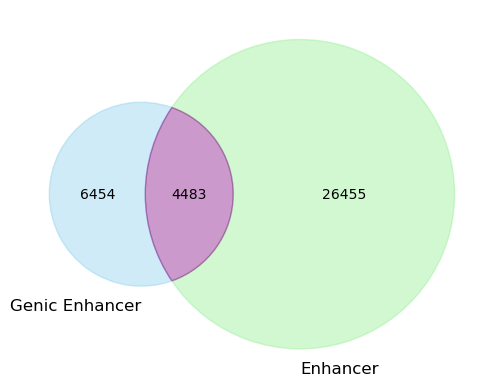

In [123]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define the sizes of the sets
set1_size = len(genic_enh_in_gene)
set2_size = len(enh_in_gene)
intersection_size = len(two_enh_in_gene)

# Create the Venn diagram
venn = venn2(subsets=(set1_size, set2_size, intersection_size),
             set_labels=('Genic Enhancer', 'Enhancer', 'Enhancer and Genic Enhancer'))

# Change the colors of each section
venn.get_patch_by_id('10').set_color('skyblue')  # Change color of genic_enh set
venn.get_patch_by_id('01').set_color('lightgreen')  # Change color of enh set
venn.get_patch_by_id('11').set_color('purple')  # Change color of intersection

In [ ]:
pickle.load("../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl")

In [73]:
path="../database/bed/unzipped/E001_15_coreMarks_stateno.bed"

In [74]:
df=bed2df_expanded(path)
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [75]:
unit_css=df2unitcss(df)

In [76]:
type(unit_css[0])

str

In [64]:
unit_css[0]=unit_css[0][50:]

In [66]:
unit_css[-1]=unit_css[-1][:-50]

In [68]:
splitted, kmerized_unit_css=css_CUT_Kmer(unit_css, cut_thres=510, k=4)

In [70]:
len(kmerized_unit_css)

30361

In [71]:
type(kmerized_unit_css)

list

In [72]:
type(kmerized_unit_css[0])

str

In [80]:
def cutKmerByCell(unzipped_bed_file_path,k=4):
    df=bed2df_expanded(path)
    unit_css=df2unitcss(df)
    assert isinstance(unit_css[0], str) 
    if len(unit_css[0])>=50 and len(unit_css[-1])>50:
        unit_css[0]=unit_css[0][50:] # cut the telomere
        unit_css[-1]=unit_css[-1][:-50] # cut the telomere
        
    _, kmerized_unit_css=css_CUT_Kmer(unit_css, cut_thres=510, k=k)
    
    filtered_kmerized_unit_css=[item for item in kmerized_unit_css if len(item)>=k]
    return filtered_kmerized_unit_css

In [81]:
filtered_kmerized_unit_css=cutKmerByCell(path,k=4)

In [88]:
output_path="../database/temp_files/whole_genome/byCellType/E001_whole_css_wo_telo.txt"

In [89]:
with open(output_path,"w") as save_file:
        save_file.write("\n".join(filtered_kmerized_unit_css))

In [ ]:
with open(fn,"w") as save_file:
        save_file.write("\n".join(ch1_unit_css_wotelo_kmer))

In [ ]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [ ]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

Check whether the Gexp_or_not fine-tuning data contain any empty line

In [9]:
path="../database/fine_tune/gene_exp/4mer/Gexp_or_not/tr_len_40k/dev.tsv"

In [10]:
df=pd.read_csv(path, engine='python', sep="\t")
df["sequence"].isna().sum()

2

In [2]:
path="../database/pretrain/expressed/4mer/whole_gene/E003_whole_gene.txt"

In [5]:
with open(path,"r") as f:
    file=f.read()

In [6]:
type(file)

str

In [14]:
file[:2000]

'OOOO OOOO OOOO OOOO OOOO OOOE OOEE OEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEED EEDD EDDD DDDD\nOOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO\nAAEE AEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEG EEGG EGGG GGGG GGGG GGGE GGEE GEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EE

In [7]:
path2="../database/wo_telo/cell15_4_wo_telo_v1.01.txt"
with open(path2,"r") as g:
    file2=g.read()
type(file2)

str

In [13]:
file2[:2000]

'OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOA OOAA OAAO AAOO AOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO\nOOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOO

In [3]:
colored_css_str_as_is("EEDDD")

EEDDD


In [4]:
colored_css_str_as_is("EEEEE")

EEEEE


In [5]:
colored_css_str_as_is("DDDDD")

DDDDD


In [6]:
colored_css_str_as_is("FFFFFFEEEEEDDDDDDDDDEEEE")

FFFFFFEEEEEDDDDDDDDDEEEE


In [8]:
len("AAAAAAAAAAAAABBGGGFEEEEE")

24

In [7]:
colored_css_str_as_is("DDDEEEEEEEEDDDDDDDDDDDDD")

DDDEEEEEEEEDDDDDDDDDDDDD


In [20]:
colored_css_str_as_is("EEEEEEEEEEEDDDDDDDEEEEEE")

EEEEEEEEEEEDDDDDDDEEEEEE


In [9]:
colored_css_str_as_is("DDDDEEEEEEEDDDDDDDDDDDEE")

DDDDEEEEEEEDDDDDDDDDDDEE


In [17]:
colored_css_str_as_is("EEEEEEEEEEEDDDDDEEEEEEEE")

EEEEEEEEEEEDDDDDEEEEEEEE


In [19]:
colored_css_str_as_is("EEEEEEEEEEEDDDDDDDEEEEDD")

EEEEEEEEEEEDDDDDDDEEEEDD


In [14]:
colored_css_str_as_is("AAAAAAAAEEEDDDDEEEEEEEGG")

AAAAAAAAEEEDDDDEEEEEEEGG


In [ ]:
colored_css_str_as_is("")

In [ ]:
colored_css_str_as_is("")

In [2]:
import pandas as pd

In [1]:
file="../database/57epigenomes.RPKM.pc.tsv"

In [3]:
df=pd.read_csv(file, sep="\t")

In [4]:
df.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,44.280,...,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818,NaN
ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,1.577,...,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000,NaN
ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,51.515,...,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371,NaN
ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,3.292,...,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714,NaN
ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,7.551,...,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491,NaN


In [5]:
len(df)

19795